In [ ]:
# Useful Links
# 1. https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# 2. https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/
# 3. https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0 (Understanding the resnet architecture for cifar10)


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf

In [2]:
# Load necessary libraries
import os
import pandas as pd
import numpy as np
#import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
#from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model




In [3]:
def load_dataset(dName="CIFAR10"):
    dataset = None
    num_classes = None
    if dName == "CIFAR10":
        num_classes = 10
        dataset = tf.keras.datasets.cifar10.load_data()
    if dName == "CIFAR100":
        num_classes = 100
        dataset = tf.keras.datasets.cifar100.load_data()
    (X_train, y_train), (X_test, y_test) = dataset
    # Convert target value to categorical values
    # One-hot-encoded target values
    y_train = to_categorical(y_train,num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    return (X_train, y_train),(X_test, y_test)

In [4]:
def divideDataset(X_train, y_train, X_test,y_test):
    dataLength = X_train.shape[0]
    trainLen=0
    dataTrain = []
    dataTest = []
    percent = 0.2
    while(trainLen<dataLength):
        trainLen = int(X_train.shape[0]*percent)
        print(X_train[:trainLen].shape)
        train = (X_train[:trainLen],y_train[:trainLen])
        retriveLen = int(X_test.shape[0]*percent)
        test = (X_test[:retriveLen],y_test[:retriveLen])
        #print(tuple(train))
        dataTrain.append(train)
        dataTest.append(test)
        print("\n")
        percent +=0.2
    return dataTrain, dataTest

In [5]:
(X_train, y_train),(X_test, y_test) = load_dataset()
dataTrain, dataTest = divideDataset(X_train, y_train, X_test, y_test) # this contains the list of 5 different datasets

170508288/170498071 [==============================] - 2s 0us/step
(10000, 32, 32, 3)


(20000, 32, 32, 3)


(30000, 32, 32, 3)


(40000, 32, 32, 3)


(50000, 32, 32, 3)




In [6]:
def describeDataset(X_train, y_train, X_test, y_test):
    print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

In [7]:
def displayImage(images=None):
    if images.any():
        # Plot a few images
        for i in range(9):
            plt.subplot(330+1+i)
            plt.imshow(images[i])
        plt.show()
    else:
        print('Error! File is empty')

In [8]:
def normalizeInput(X_train,X_test):
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    mean = np.mean(X_train, axis=(0,1,2,3))
    std = np.std(X_train,axis=(0,1,2,3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    
    return X_train, X_test

In [9]:
# plot diagnostic learning curves
def plotLearningCurve(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()
    plt.close()

In [10]:
(X_train, y_train),(X_test, y_test) = load_dataset()
describeDataset(X_train,y_train,X_test,y_test)

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


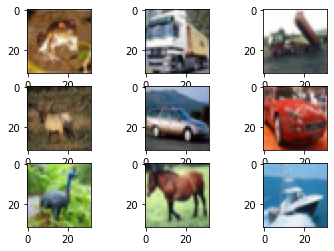

In [11]:
displayImage(X_train) # Need to pass a numpy array

In [12]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(X_train, y_train, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(X_test, y_test, batch_size=batch_size) # so as valid_lab

In [13]:
X_train, X_test = normalizeInput(dataTrain[0][0], dataTest[0][0])
y_train = dataTrain[0][1]
y_test = dataTest[0][1]

In [14]:
# define cnn model
def defineModel():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
#model = defineModel()
#history = model.fit(X_train,y_train,epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2)

In [ ]:
#plotLearningCurve(history)

# ResNet Implementation

In [ ]:
# Code Link: https://github.com/Gurupradeep/CIFAR-10-Object-Recognition-in-Images/blob/master/Models/ResNet.ipynb

In [ ]:
if data_augmentation :
    print("-------------Using Data augmentation------------")
     # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    datagen.fit(X_train)
    model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=epochs,verbose=1,validation_data=(X_test,y_test),callbacks = [lr_reducer,csv_logger])
    
else :
    print("-----Not Using Data augmentation---------------")
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True,callbacks = [csv_logger])

# RESNET50 WITH SKIP CONNECTION 4: Implemented by Lokesh

In [15]:
def createStageOne(x, f,k, s,p,counter):
  '''
  Argument
  x - input
  f - filter_size
  k - kernel size
  s - stride
  p - padding
  '''
  block_name = 'stage_1'+counter
  x_skip = x
  layers = len(f)
  for i in range(layers):
    x = Conv2D(f[i],kernel_size=(k[i],k[i]),strides=(s[i],s[i]),padding=p[i])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
  x = Conv2D(f[layers-1],kernel_size=(k[layers-1],k[layers-1]),strides=(s[layers-1],s[layers-1]),padding=p[layers-1],name=block_name+'b')(x)
  x = BatchNormalization()(x)
  print(x.shape)

  x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('relu')(x)
  print("Stage 1:", (x_skip.shape,x.shape))

  return x


In [16]:
def createStageTwo_(x, f,k, s,p,counter):
  '''
  Argument
  x - input
  f - filter_size
  k - kernel size
  s - stride
  p - padding
  '''
  block_name = 'stage_2'+counter
  x_skip = x
  print("Recevied Input at Stage 2: ", x.shape)
  layers = len(f)
  for i in range(layers):
    x = Conv2D(f[i],kernel_size=(k[i],k[i]),strides=(s[i],s[i]),padding=p[i])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
  x = Conv2D(f[layers-1],kernel_size=(k[layers-1],k[layers-1]),strides=(s[layers-1],s[layers-1]),padding=p[layers-1],name=block_name+'b')(x)
  x = BatchNormalization()(x)
  print(x.shape)

  if x.shape[1] != x_skip.shape[1]:
    x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(2,2),padding='valid')(x_skip)
  else:
    x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)

  x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('relu')(x)
  print("Stage 2:", (x_skip.shape,x.shape))

  return x


In [17]:
def createStageThree_(x, f,k, s,p,counter):
  '''
  Argument
  x - input
  f - filter_size
  k - kernel size
  s - stride
  p - padding
  '''
  block_name = 'stage_3'+counter
  x_skip = x
  print("Recevied Input at Stage 3: ", x.shape)
  layers = len(f)
  for i in range(layers):
    x = Conv2D(f[i],kernel_size=(k[i],k[i]),strides=(s[i],s[i]),padding=p[i])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
  x = Conv2D(f[layers-1],kernel_size=(k[layers-1],k[layers-1]),strides=(s[layers-1],s[layers-1]),padding=p[layers-1],name=block_name+'b')(x)
  x = BatchNormalization()(x)
  print(x.shape)

  if x.shape[1] != x_skip.shape[1]:
    x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(2,2),padding='valid')(x_skip)
  else:
    x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)

  x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('relu')(x)
  print("Stage 3:", (x_skip.shape,x.shape))

  return x

In [18]:
def createStageFour_(x, f,k, s,p,counter):
  '''
  Argument
  x - input
  f - filter_size
  k - kernel size
  s - stride
  p - padding
  '''
  block_name = 'stage_4'+counter
  x_skip = x
  print("Recevied Input at Stage 4: ", x.shape)
  layers = len(f)
  for i in range(layers):
    x = Conv2D(f[i],kernel_size=(k[i],k[i]),strides=(s[i],s[i]),padding=p[i])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
  x = Conv2D(f[layers-1],kernel_size=(k[layers-1],k[layers-1]),strides=(s[layers-1],s[layers-1]),padding=p[layers-1],name=block_name+'b')(x)
  x = BatchNormalization()(x)
  print(x.shape)

  if x.shape[1] != x_skip.shape[1]:
    x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(2,2),padding='valid')(x_skip)
  else:
    x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)

  x_skip = Conv2D(f[layers-1],kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('relu')(x)
  print("Stage 4:", (x_skip.shape,x.shape))

  return x

In [21]:
def resnet50():
  inputs = Input(shape = (32,32,3), name = "image_input")
  x = ZeroPadding2D((3,3))(inputs)
  # Initial Convolutional block
  
  x = Conv2D(64, kernel_size=(7,7), strides = (2,2))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  print("before Max pooling: ", x.shape)
  x = MaxPooling2D((3,3),strides=(2,2))(x)
  x = createStageOne(x,[64,64,256,64],[1,3,1,1],[1,1,1,1],['valid','same','valid','valid'],'1')
  x = createStageOne(x,[64,256,64,64],[3,1,1,3],[1,1,1,1],['same','valid','valid','same'],'2')

  x = createStageTwo_(x,[256,128,128,512],[1,1,3,1],[1,2,1,1],['valid','valid','same','valid'],'3')
  x = createStageTwo_(x,[128,128,512,128],[1,3,1,1],[1,1,1,1],['valid','same','valid','valid'],'4')
  x = createStageTwo_(x,[128,512,128,128],[3,1,1,3],[1,1,1,1],['same','valid','valid','same'],'5')

  x = createStageThree_(x, [512,256,256,1024],[1,1,3,1],[1,2,1,1],['valid','valid','same','valid'],'6')
  x = createStageThree_(x, [256,256,1024,256],[1,3,1,1],[1,1,1,1],['valid','same','valid','valid'],'7')
  x = createStageThree_(x, [256,1024,256,256],[3,1,1,3],[1,1,1,1],['same','valid','valid','same'],'8')
  x = createStageThree_(x, [1024,256,256,1024],[1,1,3,1],[1,1,1,1],['valid','valid','same','valid'],'9')


  x = createStageFour_(x,[256,256,1024,512],[1,3,1,1],[1,1,1,2],['valid','same','valid','valid'],'10')
  x = createStageFour_(x,[512,2048,512,512],[3,1,1,3],[1,1,1,1],['same','valid','valid','same'],'11')
  x = createStageFour_(x,[2048,512,512,2048],[1,1,3,1],[1,1,1,1],['valid','valid','same','valid'],'12')

  x = AveragePooling2D((2,2),padding='same')(x)
  x = Flatten()(x)
  x = Dense(10,activation='softmax')(x)
  model = Model(inputs=inputs,outputs=x, name='LResNet50')
  print(x.shape)
  return model


In [ ]:
model = resnet50()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

In [23]:
X_train, X_test = normalizeInput(dataTrain[4][0], dataTest[4][0])
y_train = dataTrain[4][1]
y_test = dataTest[4][1]
history = model.fit(X_train,y_train, epochs=50,batch_size=256,validation_split=0.2,verbose=1)

Epoch 1/50
157/157 [==============================] - 33s 112ms/step - loss: 2.1865 - accuracy: 0.2277 - val_loss: 2.4934 - val_accuracy: 0.1257
Epoch 2/50
157/157 [==============================] - 16s 100ms/step - loss: 1.7958 - accuracy: 0.3530 - val_loss: 1.9682 - val_accuracy: 0.3057
Epoch 3/50
157/157 [==============================] - 16s 100ms/step - loss: 1.6229 - accuracy: 0.4163 - val_loss: 1.6954 - val_accuracy: 0.4022
Epoch 4/50
157/157 [==============================] - 16s 99ms/step - loss: 1.5125 - accuracy: 0.4583 - val_loss: 1.7930 - val_accuracy: 0.3991
Epoch 5/50
157/157 [==============================] - 16s 100ms/step - loss: 1.3793 - accuracy: 0.5092 - val_loss: 1.6287 - val_accuracy: 0.4542
Epoch 6/50
157/157 [==============================] - 16s 100ms/step - loss: 1.3337 - accuracy: 0.5250 - val_loss: 1.6954 - val_accuracy: 0.4677
Epoch 7/50
157/157 [==============================] - 16s 99ms/step - loss: 1.2453 - accuracy: 0.5622 - val_loss: 29.2989 - val_acc

In [ ]:
print(history.history)

{'loss': [1.0404103994369507, 1.3772042989730835, 1.6728405952453613, 1.6283479928970337, 1.5821757316589355, 1.3873130083084106, 1.3101754188537598, 1.2028965950012207, 1.137084722518921, 0.9908014535903931, 0.8763704299926758, 1.1930948495864868, 1.0110224485397339, 1.1539664268493652, 0.9375408887863159, 0.7819269299507141, 0.7348579168319702, 0.9633705019950867, 0.7667824625968933, 0.6558874845504761, 1.3729369640350342, 1.0847262144088745, 0.8843026161193848, 0.7458209991455078, 0.6131382584571838, 0.5300760269165039, 0.46281006932258606, 0.40523627400398254, 0.36925584077835083, 0.3271966576576233, 0.28774988651275635, 0.2690630555152893, 0.24232719838619232, 0.23277275264263153, 0.22604086995124817, 0.1919366419315338, 0.19331084191799164, 0.17214369773864746, 0.647463321685791, 0.2645554542541504, 0.1981743425130844, 0.145591601729393, 0.14738397300243378, 0.13133396208286285, 0.1300162523984909, 0.13706858456134796, 0.12015694379806519, 0.35906437039375305, 0.13366788625717163

In [ ]:
def plotLearningCurve(history):
    # plot loss
    epochs = [i for i in range(50) ]
    plt.title('Cross Entropy Loss')
    plt.plot(epochs,history.history['loss'], color='blue', label='train')
    plt.plot(epochs,history.history['val_loss'], color='orange', label='test')
    plt.legend(['Train Loss','Validation Loss'])
    plt.show()
    plt.close()


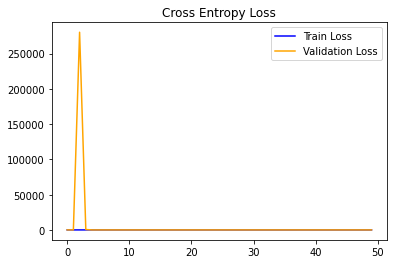

In [ ]:
plotLearningCurve(history)